In [ ]:
import numpy as np
import pandas as pd
import os, math, random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

#**Loading Data**

In [ ]:
base_path = "/content/drive/MyDrive/UORED_acoustic_spectrograms_512"
assert os.path.isdir(base_path), f"Path not found , {base_path}"

# Transforms
image_size = 224
train_tfms = transforms.Compose([
    transforms.Resize ((image_size, image_size)),
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_tfms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Base dataset
base_ds = datasets.ImageFolder(base_path)
class_names = base_ds.classes
labels = [lbl for _,lbl in base_ds.samples]


# Split Train(70%) + Temp(30%)
train_idx, temp_idx = train_test_split(
    range(len(labels)), test_size=0.3, stratify=labels, random_state=42
)

# Split Temp into Val(15%) + Test(15%)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42
)
# Datasets
train_ds = Subset(datasets.ImageFolder(base_path, transform=train_tfms), train_idx)
val_ds   = Subset(datasets.ImageFolder(base_path, transform=val_tfms), val_idx)
test_ds  = Subset(datasets.ImageFolder(base_path, transform=val_tfms), test_idx)

# Dataloaders
batch_size, num_workers = 32, 2
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 34440, Val: 7380, Test: 7380


#**Checking**

In [ ]:
print("Classes:", class_names)
print("Total images:", len(base_ds))
print("Train/Val/test sizes:", len(train_ds), len(val_ds), len(test_ds))

# Per-class counts (train/val)
from collections import Counter
train_counts = Counter([labels[i] for i in train_idx])
val_counts   = Counter([labels[i] for i in val_idx])
print("Per-class train counts:", {class_names[k]: v for k, v in train_counts.items()})
print("Per-class val counts:",   {class_names[k]: v for k, v in val_counts.items()})

# Peek one batch
imgs, ys = next(iter(train_loader))
print("One train batch tensor:", imgs.shape, "labels shape:", ys.shape)

Classes: ['1_Healthy', '2_Inner_Race_Faults', '3_Outer_Race_Faults', '4_Ball_Faults', '5_Cage_Faults']
Total images: 49200
Train/Val/test sizes: 34440 7380 7380
Per-class train counts: {'1_Healthy': 11480, '2_Inner_Race_Faults': 5740, '4_Ball_Faults': 5740, '3_Outer_Race_Faults': 5740, '5_Cage_Faults': 5740}
Per-class val counts: {'3_Outer_Race_Faults': 1230, '5_Cage_Faults': 1230, '1_Healthy': 2460, '2_Inner_Race_Faults': 1230, '4_Ball_Faults': 1230}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


One train batch tensor: torch.Size([32, 3, 224, 224]) labels shape: torch.Size([32])


#**MODEL TRAINING**

In [ ]:
pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 49.2 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
import timm
from torch import nn

class ViTClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=0.05)


In [ ]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

logger = CSVLogger("logs", name="vit_model")

checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/ViTs_audio_checkpoint",
    filename="vit-{epoch:02d}-{val_acc:.4f}",
    monitor="val_acc",
    mode="max",
    save_top_k=1
)

model = ViTClassifier(num_classes=len(class_names), lr=1e-4)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=1,
    precision=16 if torch.cuda.is_available() else 32,
    log_every_n_steps=10,
    logger=logger,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, train_loader, val_loader)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory /content/drive/MyDrive/ViTs_audio_checkpoint exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | VisionTransformer | 5.5 M  | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.102    Total estimated model params size (MB)
277       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


#**LOADING MODEL**

In [ ]:
# Path where checkpoints were saved
ckpt_path = "/content/drive/MyDrive/ViTs_audio_checkpoint"

# Find best checkpoint path (manually or from callback.best_model_path)
best_ckpt = sorted([f for f in os.listdir(ckpt_path) if f.endswith(".ckpt")])[-1]
best_ckpt_path = os.path.join(ckpt_path, best_ckpt)

print("Loading best checkpoint:", best_ckpt_path)

# Reload model
best_model = ViTClassifier.load_from_checkpoint(
    best_ckpt_path,
    num_classes=len(class_names),
    lr=1e-4
)


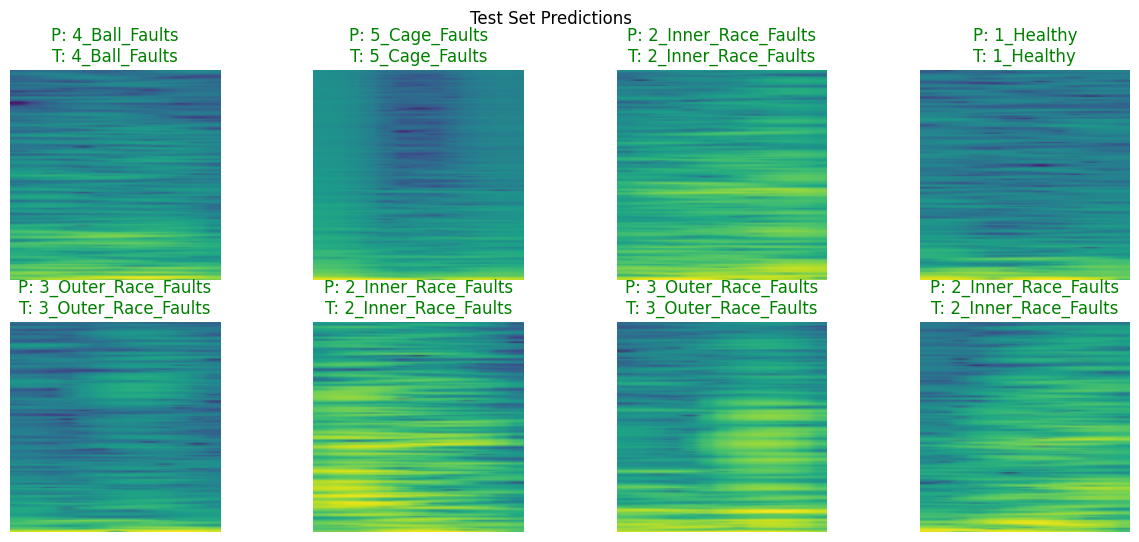

In [ ]:
import matplotlib.pyplot as plt

def show_test_predictions(test_loader, model, class_names, n_samples=8):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    imgs, labels = next(iter(test_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    with torch.no_grad():
        preds = model(imgs).argmax(dim=1)

    # Plot first n_samples
    plt.figure(figsize=(15, 6))
    for i in range(n_samples):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # de-normalize
        img = img.clip(0,1)

        true_label = class_names[labels[i].item()]
        pred_label = class_names[preds[i].item()]

        plt.subplot(2, n_samples//2, i+1)
        plt.imshow(img)
        plt.axis("off")
        color = "green" if true_label == pred_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color)

    plt.suptitle("Test Set Predictions")
    plt.show()

# Example usage:
show_test_predictions(test_loader, best_model, class_names, n_samples=8)
